# Testing different network topologies in NEST

This notebook simulates a network of 8 leaky integrate-and-fire (LIF) neurons with different topologies using the NEST simulator.
It includes a function to connect neurons based on specified topologies, such as lattice, small-world, and random.

In [1]:
# Import the necessary libraries
import nest
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Simulation Setup ---
# Reset the NEST kernel to ensure a clean simulation environment
nest.ResetKernel()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: May  5 2025 12:51:17

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## 2. Network Parameters
Here we define the size of our network and its grid dimensions.

In [2]:
# Set the simulation time in milliseconds
simulation_time = 500.0  # Adjust this value as needed
# Set the random seed for reproducibility
nest.SetKernelStatus({"rng_seed": 42})

# Total number of neurons in the network
num_neurons = 8

In [3]:
# Neuron parameters
neuron_params = {
	"E_L": -60.0,  # Resting potential
    "C_m": 250.0,  # Membrane capacitance
    "tau_m": 10.0,  # Membrane time constant
	"t_ref": 2.0,  # Refractory period
    "V_th": -55.0,  # Spike threshold
	"V_reset": -60.0,  # Reset potential after a spike
	"I_e": 0.0,  # No constant input current
}

## 3. Create Network Nodes
We will create the neurons, a spike generator for stimulus, and devices to record activity.

In [4]:
# Create the 8 neurons using the leaky integrate-and-fire model
# with exponential post-synaptic currents.
neurons = nest.Create("iaf_psc_exp", num_neurons, params=neuron_params)
neurons.V_m = neuron_params["E_L"]  # Initialize membrane potential to resting potential

# Create a spike generator to provide input stimulus to the network
spike_generator = nest.Create("spike_generator")
# Set the spike times for the generator. It will send a single spike at 10.0 ms.
spike_generator.spike_times = [10.0]

# Create a voltmeter to record the membrane potential of the neurons
voltmeter = nest.Create("voltmeter")

# Create a spike recorder to capture spike events
spike_recorder = nest.Create("spike_recorder")

## 4. Connect the Network

In [5]:
# Topology: Modified hub-and-spoke

# Synapse parameters
# input_current = 300.0 	# Input current for the first neuron
# input_weight = 0.0  	# Weight for the synaptic connections
# synapse_weight = 1000.0 # Weight for the synaptic connections

# nest.Connect(neurons[0], neurons[1], syn_spec={"weight": synapse_weight})

# nest.Connect(neurons[1], neurons[2, 3, 4], syn_spec={"weight": synapse_weight})

# nest.Connect(neurons[2], neurons[3, 4, 5], syn_spec={"weight": synapse_weight})
# nest.Connect(neurons[3], neurons[1, 5], syn_spec={"weight": synapse_weight})
# nest.Connect(neurons[4], neurons[2, 3, 5], syn_spec={"weight": synapse_weight})

# nest.Connect(neurons[5], neurons[2, 3, 4], syn_spec={"weight": -2.0*synapse_weight})

In [6]:
# Topology: Closed ring

# Synapse parameters
# input_current = 0.0 	# Input current for the first neuron
# input_weight = 1000.0  	# Weight for the synaptic connections
# synapse_weight = 1000.0 # Weight for the synaptic connections

# # Connect each neuron with next two neurons in the chain
# for i in range(8):
# 	if i<7:
# 		# Connect the current neuron to the next two neurons in the chain
# 		nest.Connect(neurons[i], neurons[i + 1], syn_spec={"weight": synapse_weight})

# # Connect the last neurons to the first two neurons to complete the chain
# nest.Connect(neurons[-1], neurons[0], syn_spec={"weight": synapse_weight})

In [ ]:
# Topology: Ring with PING modulation

# Synapse parameters
input_current = 200.0 	# Input current for the first neuron
input_weight = 0.0  	# Weight for the synaptic connections
excitatory_weight = 1000.0 # Weight for the synaptic connections
inhibitory_weight = -800.0  # Weight for inhibitory connections

nest.Connect(neurons[0], neurons[1, 2, 3], syn_spec={"weight": excitatory_weight})
# nest.Connect(neurons[0], neurons[1], syn_spec={"weight": excitatory_weight})

# First ring connection for 3 excitatory neurons
for i in range(1, 4):
	if i < 3:
		nest.Connect(neurons[i], neurons[i + 1], syn_spec={"weight": 0.8*excitatory_weight})
	else:
		nest.Connect(neurons[i], neurons[1], syn_spec={"weight": 0.8*excitatory_weight})

# Create PING modulation connections
nest.Connect(neurons[1], neurons[4], syn_spec={"weight": 0.8*excitatory_weight})
nest.Connect(neurons[4], neurons[1], syn_spec={"weight": inhibitory_weight})

nest.Connect(neurons[2], neurons[5], syn_spec={"weight": 0.8*excitatory_weight})
nest.Connect(neurons[5], neurons[2], syn_spec={"weight": inhibitory_weight})

nest.Connect(neurons[3], neurons[6], syn_spec={"weight": 0.8*excitatory_weight})
nest.Connect(neurons[6], neurons[3], syn_spec={"weight": inhibitory_weight})

# Change the E to I weights with different values for the different PING's to desynchronize it

## 5. Connect Devices
Now we connect the spike generator and recording devices to the appropriate neurons.

In [8]:
# Connect the spike generator to the first neuron in the network (index 0).
# This will be the entry point for the stimulus.
nest.Connect(spike_generator, neurons[0], syn_spec={"weight": input_weight})
neurons[0].I_e = input_current  # Set a constant input current for the first neuron

# Connect the voltmeter to all neurons to record their membrane potential.
nest.Connect(voltmeter, neurons)

# Connect all neurons to the spike recorder.
nest.Connect(neurons, spike_recorder)

## 6. Run the Simulation

In [9]:
# Simulate the network
nest.Simulate(simulation_time)


Aug 20 23:01:57 NodeManager::prepare_nodes [Info]: 
    Preparing 11 nodes for simulation.

Aug 20 23:01:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 11
    Simulation time (ms): 500
    Number of OpenMP threads: 1
    Not using MPI

Aug 20 23:01:57 SimulationManager::run [Info]: 
    Simulation finished.


## 7. Visualize the Results
Finally, we plot the membrane potentials and spike times recorded by our devices to observe the network's activity.

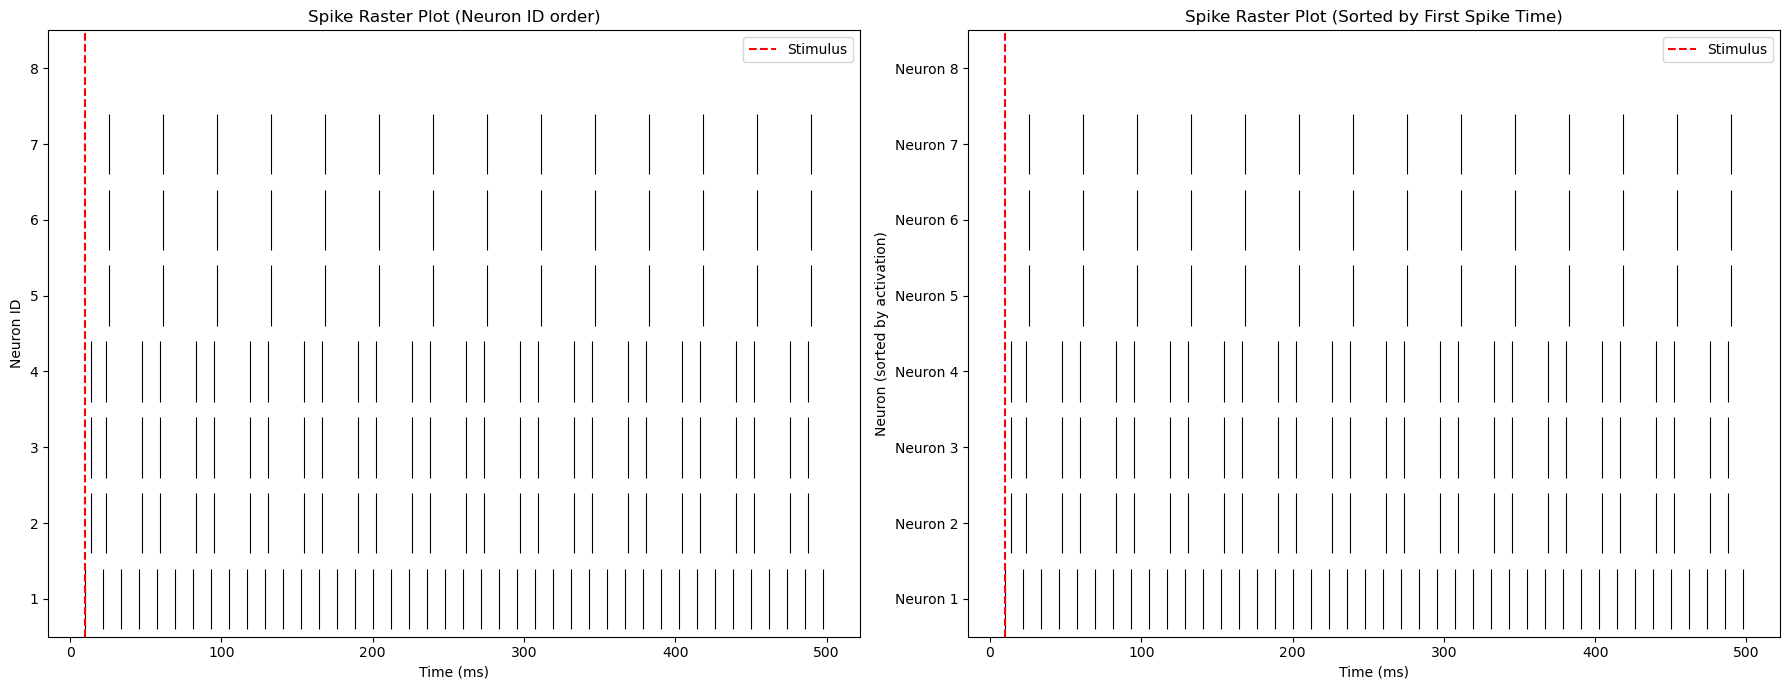

In [10]:
# Side-by-side raster plots: original and sorted by first spike time, with neuron IDs
events = nest.GetStatus(spike_recorder, "events")[0]
senders = np.array(events["senders"])
times = np.array(events["times"])

# --- Prepare sorted neuron order and labels ---
first_spike_times = []
for n in range(1, num_neurons + 1):
    neuron_times = times[senders == n]
    if len(neuron_times) > 0:
        first_spike_times.append((n, neuron_times[0]))
    else:
        first_spike_times.append((n, np.nan))
first_spike_times_sorted = sorted(first_spike_times, key=lambda x: (np.nan_to_num(x[1], nan=1e9)))
sorted_ids = [x[0] for x in first_spike_times_sorted]
sorted_labels = [f"Neuron {nid}" for i, nid in enumerate(sorted_ids)]

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharex=True)

# --- Original raster ---
axes[0].set_title('Spike Raster Plot (Neuron ID order)')
line_len = 0.8
axes[0].vlines(times, senders - line_len / 2, senders + line_len / 2, color='k', linewidth=0.8)
axes[0].axvline(10.0, color='r', linestyle='--', label='Stimulus')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Neuron ID')
axes[0].set_yticks(range(1, num_neurons + 1))
axes[0].set_ylim(0.5, num_neurons + 0.5)
axes[0].legend()

# --- Sorted raster ---
for idx, n in enumerate(sorted_ids):
    neuron_times = times[senders == n]
    axes[1].vlines(neuron_times, idx + 1 - 0.4, idx + 1 + 0.4, color='k', linewidth=0.8)
axes[1].axvline(10.0, color='r', linestyle='--', label='Stimulus')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Neuron (sorted by activation)')
axes[1].set_title('Spike Raster Plot (Sorted by First Spike Time)')
axes[1].set_yticks(range(1, num_neurons + 1))
axes[1].set_yticklabels(sorted_labels)
axes[1].set_ylim(0.5, num_neurons + 0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

In [11]:
# # Animation with circles for neurons, flashing on spike
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# # Define the grid dimensions for the square lattice (2 rows, 4 columns)
# grid_rows = 2
# grid_cols = 4

# # Get spike times for each neuron
# events = nest.GetStatus(spike_recorder, "events")[0]
# senders = np.array(events["senders"])
# times = np.array(events["times"])
# spike_times_grid = [[[] for _ in range(grid_cols)] for _ in range(grid_rows)]
# for n in range(1, num_neurons + 1):
#     neuron_times = times[senders == n]
#     row = (n - 1) // grid_cols
#     col = (n - 1) % grid_cols
#     spike_times_grid[row][col] = neuron_times

# # Animation parameters
# t_min = 0
# t_max = simulation_time
# dt = 0.5
# frames = int((t_max - t_min) / dt) + 1
# time_points = np.linspace(t_min, t_max, frames)

# fig, ax = plt.subplots(figsize=(8, 4))
# ax.set_xlim(-0.5, grid_cols-0.5)
# ax.set_ylim(-0.5, grid_rows-0.5)
# ax.set_xticks(range(grid_cols))
# ax.set_yticks(range(grid_rows))
# ax.set_xlabel('Column')
# ax.set_ylabel('Row')
# ax.set_title('Spike Propagation Animation (Circles)')

# # Draw circles for neurons
# circles = []
# for i in range(grid_rows):
#     for j in range(grid_cols):
#         circle = plt.Circle((j, i), 0.3, color='gray', ec='black')
#         ax.add_patch(circle)
#         circles.append(circle)

# def update(frame):
#     t = time_points[frame]
#     for idx, circle in enumerate(circles):
#         i = idx // grid_cols
#         j = idx % grid_cols
#         # Flash if neuron spikes within this frame
#         if any((st > t-dt/2) and (st <= t+dt/2) for st in spike_times_grid[i][j]):
#             circle.set_color('yellow')
#             circle.set_radius(0.4)
#         else:
#             circle.set_color('gray')
#             circle.set_radius(0.3)
#     ax.set_title(f'Spike Propagation at t={t:.1f} ms')
#     return circles

# ani = FuncAnimation(fig, update, frames=frames, interval=100, blit=True)
# plt.close(fig)

# HTML(ani.to_jshtml())